In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import json

import torch
from torchvision.utils import save_image
import networkx as nx
from matplotlib import pyplot as plt

from minimal.arch import Generator
from minimal.dataset import FloorplanGraphDataset
from minimal.utils import (
    init_input,
    draw_masks,
    draw_graph
)

%matplotlib inline

In [5]:
PRETRAINED_PATH = "./checkpoints/pretrained.pth"
DATA_PATH = "./data/sample_list.txt"
OUT_PATH = "./dump"

In [7]:
fp_dataset = FloorplanGraphDataset(DATA_PATH)

In [6]:
model = Generator()
model.load_state_dict(
    torch.load(PRETRAINED_PATH, map_location=torch.device("cpu")), strict=True
)
model = model.eval()

In [11]:
sample = next(iter(fp_dataset))

In [27]:
def _infer(graph, model, prev_state=None):
    z, given_masks_in, given_nds, given_eds = init_input(graph, prev_state)

    with torch.no_grad():
        masks = model(z, given_masks_in, given_nds, given_eds)
        masks = masks.detach().cpu().numpy()

    return masks

In [26]:
NUM_ITERS = 10

_, nds, eds = sample
graph = [nds, eds]

rms_type_z = np.where(nds==1)[1]
_types = sorted(list(set(rms_type_z)))
selected_types = [_types[:k+1] for k in range(NUM_ITERS)]

In [28]:
masks = _infer(graph, model, { "masks": None, "fixed_nodes": [] })

/home/radium/ser/follows/houseganpp/minimal/utils.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  given_eds = torch.tensor(given_eds).long()
/home/radium/ser/follows/houseganpp/minimal/utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  given_masks = torch.tensor(prev_mks)


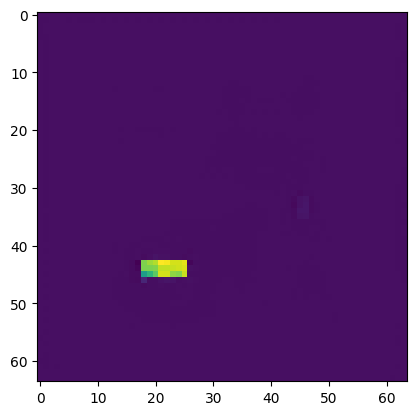

In [35]:
plt.imshow(masks[-1])

In [40]:
rms_type_z

array([ 4,  2,  2,  3,  1,  0, 16, 16, 16, 16, 16, 14])

In [48]:
nds.dtype, nds.float().dtype

(torch.float32, torch.float32)